In [3]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import statistics
import math

In [ ]:
h1 = nc.Dataset('S5P_OFFL_L1C_SIFTPC_20240206T123417_20240206T123957_32732_93_000001_20241120T170117.nc')
africa = h1.groups['africa']

In [141]:
#Identify scanline in groundpixel 224 with clouds
scanline = africa.variables['scanline']
groundpixel = africa.variables['ground_pixel']
scanline_nocloud = []
for n in range(406):
    if africa.variables['CloudFraction'][0,n,224]<0.5:
        scanline_nocloud.append(n)
len(scanline_nocloud)

370

In [142]:
#Fixing albedo 
import numpy.polynomial.polynomial as po
def indexate(wl, ranges):
    if isinstance(ranges[0], (int, float)):  # Single range
        start, end = ranges
        return np.where((wl >= start) & (wl <= end))[0]
    else:  # Multiple ranges
        indices = np.concatenate([np.where((wl >= start) & (wl <= end))[0] for start, end in ranges])
        return np.sort(indices)
#len(africa.variables['Reflectance_wl'][0, 0 , 224, :]) ##this is how you check when reflectance wavelength starts and ends and its length
wl = np.linspace(700.06,785.16,692) #Define the wavelenth in terms of the spectral channels 
retrievalWindow = (734, 758) # retrieval wavelength window [nm]
windowsOfNoAbsorption = ((712, 713), (748, 757), (775, 785)) # windows for no atmospheric absorption [nm]
sb_order = 2 # order of polynomial fit of surface reflectivity (barren)
ind    = indexate(wl, retrievalWindow)
ind_na = indexate(wl, windowsOfNoAbsorption)
ref_na = africa.variables["Reflectance"][0, scanline_nocloud, 224, ind_na].data.tolist()

#for each scanline model the albedo with the noabsobtion window of reflectance
surf_albedo = np.zeros((370, 195))
for i in range(370):
    poly_sa = po.polyfit (wl[ind_na], ref_na[i], sb_order)
    surf_alb = po.polyval (wl[ind], poly_sa) 
    surf_albedo[i, :] = surf_alb

In [150]:
#Computing tau
mu = np.cos(np.radians(africa.variables["VZA"][0,scanline_nocloud,224]))
mu_0 = np.cos(np.radians(africa.variables["SZA"][0,scanline_nocloud,224]))
mu_matrix = np.cos(np.tile(mu[:, np.newaxis], 195))
mu_0_matrix = np.cos(np.tile(mu_0[:, np.newaxis], 195))
reflectance_matrix = africa.variables['Reflectance'][0, scanline_nocloud, 224, 276:471].data

tau = -np.log(reflectance_matrix/surf_albedo)/ (np.reciprocal(mu_matrix)+ np.reciprocal(mu_0_matrix))

(370, 195)

In [160]:
ind_tensor = torch.tensor(ind, dtype=torch.float32).reshape(-1, 1)
tau_tensor = torch.tensor(tau.transpose(), dtype=torch.float32).unsqueeze(1) #195x1x406
target_tau = torch.tensor(tau.mean(axis = 0), dtype=torch.float32).reshape(-1,1)
tau_tensor.shape, target_tau.shape
from torch.utils.data import DataLoader, TensorDataset, random_split

# Split into training and test sets (80% train, 20% test)
train_size = int(0.8 * tau_tensor.shape[0])
test_size = tau_tensor.shape[0] - train_size

train_dataset, test_dataset = random_split(TensorDataset(tau_tensor, target_tau), [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [145]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [161]:
class SimpleSpectralCNN(nn.Module):
    def __init__(self):
        super(SimpleSpectralCNN, self).__init__()
        # First convolutional layer: in_channels=1, out_channels=16, kernel_size=3
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        # Second convolutional layer: increasing the feature channels
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        # A pooling layer to reduce dimensionality and capture invariance
        self.pool = nn.MaxPool1d(kernel_size=2)
        # Fully connected layer to map the extracted features to your output
        # We need to compute the size after the convolutions and pooling.
        # For an input length of 195, after one pooling (kernel 2) the length becomes ~97 or 98.
        # For simplicity, let's assume it reduces to 97, and with 32 channels: 32*97.
        self.fc = nn.Linear(32 * 185, 1)  # For a regression output

    def forward(self, x):
        x = F.relu(self.conv1(x))  
        x = F.relu(self.conv2(x)) 
        x = self.pool(x)           
        x = x.view(x.size(0), -1)  
        x = self.fc(x)             
        return x

# Instantiate the model
model = SimpleSpectralCNN()

In [164]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [163]:
num_epochs = 10000
train_losses, test_losses = [], []

for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()

    train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(train_loss)

    # Evaluation
    model.eval()
    epoch_test_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            test_preds = model(X_batch)
            test_loss = criterion(test_preds, y_batch)
            epoch_test_loss += test_loss.item()

    test_loss = epoch_test_loss / len(test_loader)
    test_losses.append(test_loss)

    if (epoch + 1) % 5000 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.6f}, Test Loss: {test_loss:.6f}")


Epoch [5000/10000], Train Loss: 0.000000, Test Loss: 0.000000
Epoch [10000/10000], Train Loss: 0.000000, Test Loss: 0.000000


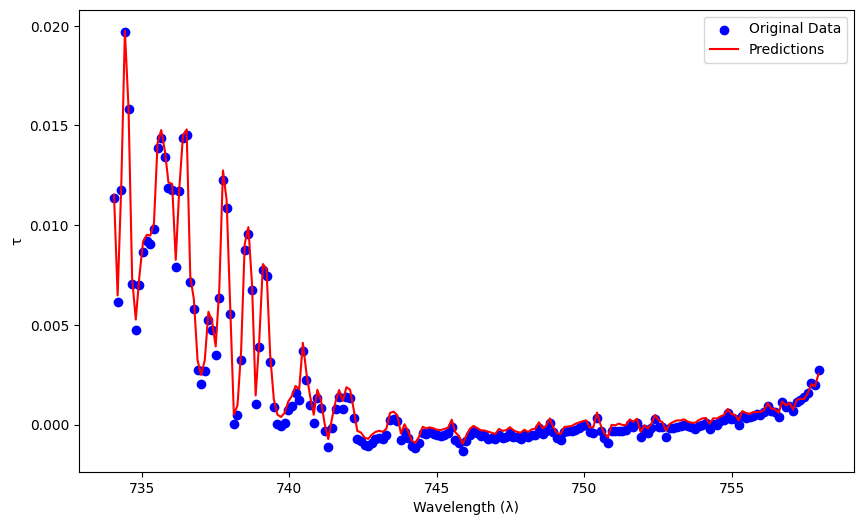

In [165]:
model.eval()
with torch.no_grad():
    predictions = model(tau_tensor).squeeze(1).numpy()  # (195,)

plt.figure(figsize=(10, 6))
plt.scatter(wl[ind], target_tau.numpy().flatten(), color='blue', label='Original Data')
plt.plot(wl[ind], predictions, color='red', label='Predictions')
plt.xlabel('Wavelength (λ)')
plt.ylabel('τ')
plt.legend()
#plt.savefig("CNN-africa")
plt.show()

In [20]:
# from sklearn.metrics import r2_score
# with torch.no_grad():
#     y_pred = model(test_dataset)
#     r2 = r2_score(y_test.numpy(), y_pred.numpy())
#     print(f"\nFinal R² Score: {r2:.4f}")

In [ ]:
###NOW retrieve SIF from Sahara --should be zero

In [251]:
#SOLAR IRRADIANCE FROM ? 
E = nc.Dataset('S5P_OPER_REF_SOLAR__00000000T000000_99999999T999999_20210107T132455.nc')
groups = E.groups
E_0 = E.groups['band_6']

wavelength = E_0["wavelength"][:]
indices = np.where((wavelength >= 734) & (wavelength <= 758))[0]
# Get irradiance_flux and subset the desired range
irradiance_flux = E_0["irradiance_flux_cf"][0, indices]
num_pixels = len(irradiance_flux)
target_size = 195
step = num_pixels // target_size  
# Average over non-overlapping groups of ground pixels
irradiance_vector = np.squeeze(np.mean(irradiance_flux[:step*target_size].reshape(target_size, step, -1), axis=1))

#CONVERTING UNITS --- Convert irradiance from mol s⁻¹ m⁻² nm⁻¹ to W m⁻² nm⁻¹
def convert_irradiance(irradiance_mol, wavelength_nm):
            """
            Convert irradiance from mol s⁻¹ m⁻² nm⁻¹ to W m⁻² nm⁻¹.
           
            Parameters:
                irradiance_mol (array): Irradiance in mol s⁻¹ m⁻² nm⁻¹
                wavelength_nm (array): Corresponding wavelengths in nm
               
            Returns:
                array: Irradiance in W m⁻² nm⁻¹
            """
            # Constants
            h = 6.626e-34  # Planck's constant (J·s)
            c = 2.998e8    # Speed of light (m/s)
            Na = 6.022e23  # Avogadro's number (photons/mol)
           
            wavelength_m = np.array(wavelength_nm) * 1e-9  # Convert nm to meters
            photon_energy = (h * c) / wavelength_m  # Energy per photon in Joules
            irradiance_watts = irradiance_mol * Na * photon_energy  # Convert to W/m²/nm
       
            # # Print a value before and after conversion
            # index = 0  # View the first value
            # print(f"Before: {irradiance_mol[index]:.5e} mol/s/m²/nm at {wavelength_nm[index]} nm")
            # print(f"After:  {irradiance_watts[index]:.5f} W/m²/nm at {wavelength_nm[index]} nm")
       
            return irradiance_watts
       
solspec = convert_irradiance(irradiance_vector, wl[ind])

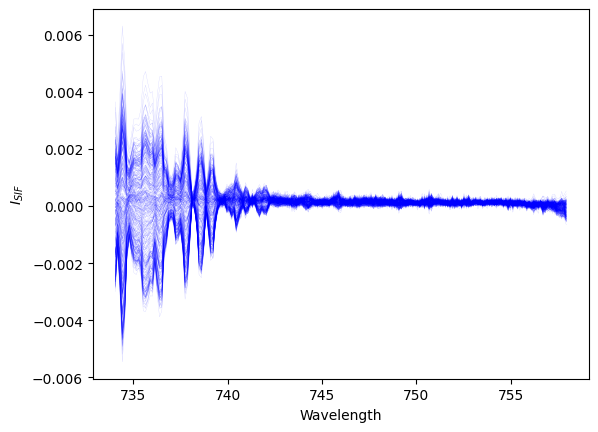

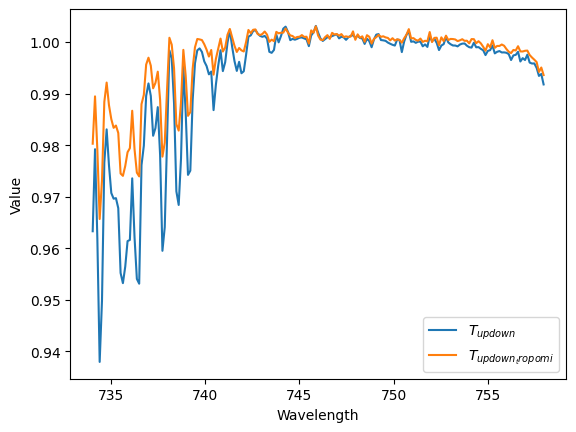

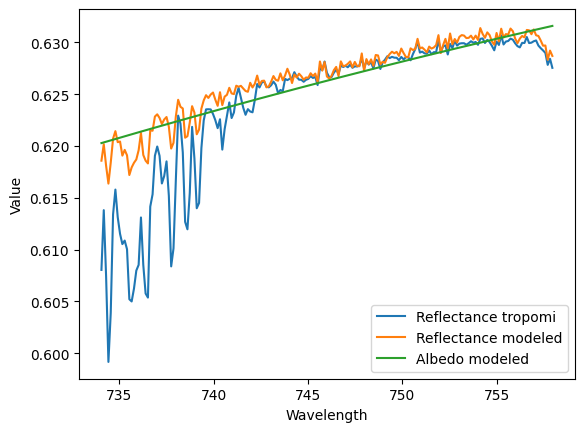

In [285]:
irradiance_matrix = np.tile(solspec.T, (370, 1))

transmitance_matrix = np.exp(-(np.reciprocal(mu_matrix)+ np.reciprocal(mu_0_matrix))*predictions)
up_transmitance_matrix = np.exp(-predictions/mu_matrix*(np.reciprocal(mu_matrix)/(np.reciprocal(mu_matrix) + np.reciprocal(mu_0_matrix))))

#this multiplication is not precisely reflect because of really small computer error as in they are not exact values 
diff = reflectance_matrix - surf_albedo*transmitance_matrix
I =irradiance_matrix*mu_0_matrix*(diff)/(up_transmitance_matrix*math.pi) #is E_0 correct??? irradiance_matrix* I removed this as it was too large 50-100!!!
for n in range(370):
    plt.plot(wl[ind],I[n], color = "blue", alpha=0.2, linewidth=0.2)
plt.xlabel('Wavelength')
plt.ylabel("$I_{SIF}$")
#plt.savefig("SIF_retrieved_africa_irrad")
plt.show()

up_transmitance_tropomi = np.exp(-tau/mu_matrix*(np.reciprocal(mu_matrix)/(np.reciprocal(mu_matrix) + np.reciprocal(mu_0_matrix))))
transmitance_tropomi = np.exp(-(np.reciprocal(mu_matrix) + np.reciprocal(mu_0_matrix))*tau)[100]
modeled_reflectance = surf_albedo*transmitance_tropomi + up_transmitance_matrix*math.pi*I/(irradiance_matrix*mu_0_matrix)

plt.plot(wl[ind], transmitance_matrix[100], label="$T_{updown}$")
plt.plot(wl[ind],transmitance_tropomi , label="$T_{updown_tropomi}$")
plt.xlabel('Wavelength')
plt.ylabel('Value')
plt.legend(loc="best")
plt.show()

plt.plot(wl[ind], reflectance_matrix[100], label="Reflectance tropomi")
plt.plot(wl[ind], modeled_reflectance[100], label="Reflectance modeled")
plt.plot(wl[ind], surf_albedo[100], label="Albedo modeled")
plt.xlabel('Wavelength')
plt.ylabel('Value')
plt.legend(loc="best")
plt.show()




In [286]:
#################NOW FOR AMAZONAS

In [288]:
h2 = nc.Dataset('S5P_OFFL_L1C_SIFTPC_20240206T172817_20240206T173755_32735_93_000001_20241120T172637.nc')
africa2 = h2.groups['africa']

In [289]:
#Identify scanline in groundpixel 224 with clouds
scanline2 = africa2.variables['scanline']
groundpixel2 = africa2.variables['ground_pixel']
scanline_nocloud2 = []
for n in range(406):
    if africa2.variables['CloudFraction'][0,n,224]<0.5:
        scanline_nocloud2.append(n)
sc_nc2 = len(scanline_nocloud2)
sc_nc = len(scanline_nocloud)
#sc_nc > sc_nc2

In [290]:
#Fixing albedo 

ref_na2 = africa2.variables["Reflectance"][0, scanline_nocloud2, 224, ind_na].data.tolist()

#for each scanline model the albedo with the noabsobtion window of reflectance
surf_alb2 = np.zeros((sc_nc2, 195))
for i in range(sc_nc2):
    poly_sa = po.polyfit (wl[ind_na], ref_na2[i], sb_order)
    surf_alb = po.polyval (wl[ind], poly_sa) 
    surf_alb2[i, :] = surf_alb



In [297]:
#Computing tau
mu2 = np.cos(np.radians(africa2.variables["VZA"][0,scanline_nocloud2,224]))
mu_02 = np.cos(np.radians(africa2.variables["SZA"][0,scanline_nocloud2,224]))
mu_matrix2 = np.cos(np.tile(mu2[:, np.newaxis], (1,195)))
mu_0_matrix2 = np.cos(np.tile(mu_02[:, np.newaxis],(1, 195)))
reflectance_matrix2 = africa2.variables['Reflectance'][0, scanline_nocloud2, 224, 276:471]


tau2 = -np.log(reflectance_matrix2/surf_alb2)/ (np.reciprocal(mu_matrix2)+ np.reciprocal(mu_0_matrix2))

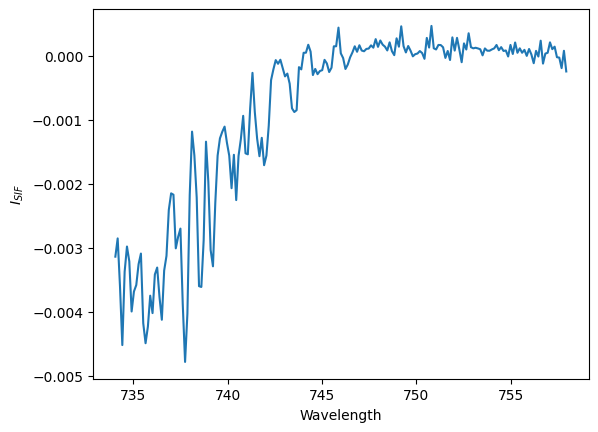

In [299]:
transmitance_matrix2 = np.exp(-(np.reciprocal(mu_matrix2)+ np.reciprocal(mu_0_matrix2))*predictions)
up_transmitance_matrix2 = np.exp(-(np.reciprocal(mu_matrix2)/(np.reciprocal(mu_matrix2) + np.reciprocal(mu_0_matrix2)))*predictions/mu_matrix2)
#this multiplication is not precisely reflect because of really small computer error as in they are not exact values 
diff2 = reflectance_matrix2 - surf_alb2*transmitance_matrix2
I = irradiance_matrix[0:sc_nc2,:]*mu_0_matrix2*(np.round(diff2, decimals=10))/(up_transmitance_matrix2*math.pi) #this I is really I/E_0  irradiance_matrix*
plt.plot(wl[ind],I[332])
#plt.plot(wl[ind], africa2.variables['Reflectance'][0, 200, 224, 276:471].data)
plt.xlabel('Wavelength')
plt.ylabel("$I_{SIF}$")
#plt.savefig("retrieved_SIF_amazonas_irrad")
plt.show()


In [304]:
#Adapt it to all the ground_pixels
SIF = []
for n in range(10): 
    reflectance_map = africa2.variables['Reflectance'][0,scanline_nocloud2,n,276:471]
    diff2 = reflectance_map - surf_alb2*transmitance_matrix2
    I = irradiance_matrix[0:sc_nc2,:]*mu_0_matrix2*(np.round(diff2, decimals=10))/(up_transmitance_matrix2*math.pi) 
    SIF.append(I)

KeyboardInterrupt: 

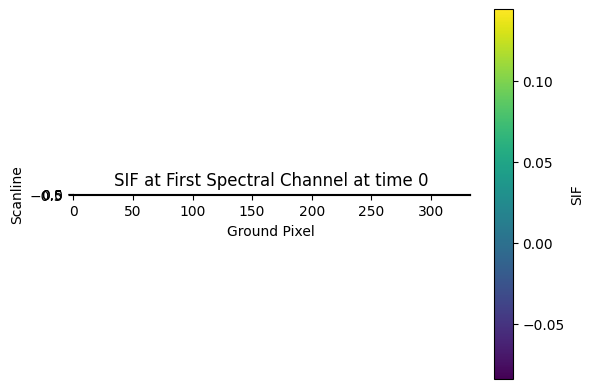

(1, 333, 195)

In [302]:
SIF_va = np.stack(SIF)
ground_pixel2 = africa2.variables['ground_pixel'][:]
scanline2 = africa2.variables['scanline'][scanline_nocloud2]
# Plot SIF over the Amazonas 448 groundpixels and 406 scanlines
plt.imshow(SIF_va[:,:,100].data, origin='lower')
plt.colorbar(label='SIF')
plt.xlabel('Ground Pixel')
plt.ylabel('Scanline')
plt.title('SIF at First Spectral Channel at time 0')
#plt.savefig('sif_colour.png')
plt.show()
SIF_va.shape